## Problem Statement
   - Obtain Terrorist Attack Clusters based on location, group name and the type of weaponry used in the attacks

**Obtain attack clusters based on location, group name and the type of weaponry used in the attacks**
   - Location based data: <code>latitude</code> and <code>longitude</code>
   - Group Name based data: <code>gname</code>
   - Weaponry based data: <code>weaptype1_txt</code>
   
**Plan of Attack**
   - Apply different clustering algorithms to the feature set 
   - Evaluate Performance using different metrics 
   - Plot Visualizations to check for appropriate no. of clusters 

---
## **Import Libraries** 
---

In [85]:
# Import libraries 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import warnings

# Edit matplotlib settings 
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

# Edit seaborn settings
sns.set(style="whitegrid")
sns.set_palette("coolwarm")
sns.set_color_codes("bright")

warnings.filterwarnings("ignore")

---
## **Data Acquisition and Description**
---

In [86]:
# Begin loading the GTD dataset 
data = pd.read_csv("data/terrorism.csv", encoding="latin-1", low_memory=False)
print(data.columns)

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)


- Here I will be selecting the top 10 most frequently occuring terrorist groups and create a new dataframe "cluster_df" containing containing specific columns from the filtered data. The process has been done keeping in mind the most significant terrorist group names for further analysis and visualization

In [87]:
# Step 1: Count the occurrences of each value in the 'gname' column, sort in descending order,
# and select the top 10 values.
valid_counts = data["gname"].value_counts().sort_values(ascending=False).head(10).index

# Step 2: Filter the original DataFrame 'data' to include only rows where the 'gname' column
# has values present in the 'valid_counts' list. 
valid_df = data[data["gname"].isin(valid_counts)]

# Step 3: Create a new DataFrame 'cluster_df' containing only the selected columns ('latitude',
# 'longitude', 'gname', 'weaptype1_txt') from the filtered DataFrame 'valid_df'.
cluster_df = valid_df[["latitude", "longitude", "gname", "weaptype1_txt"]]

In [88]:
cluster_df["gname"].unique()

array(['Unknown', 'Liberation Tigers of Tamil Eelam (LTTE)', 'Maoists',
       'Sikh Extremists', "People's Liberation Front (JVP)",
       'United Liberation Front of Assam (ULFA)', 'Taliban',
       'Communist Party of India - Maoist (CPI-Maoist)',
       'Tehrik-i-Taliban Pakistan (TTP)',
       'Khorasan Chapter of the Islamic State'], dtype=object)

In [89]:
# Group the 'valid_df' DataFrame by 'gname' and count occurrences of each 'weaptype1_txt'.
group_weapon_tot = valid_df.groupby("gname")["weaptype1_txt"].count().to_dict()

# Define a function 'attack_percent' to retrieve the count of 'weaptype1_txt' for a given 'gname'.
def attack_percent(row):
    return group_weapon_tot[row["gname"]]
cluster_df["attack_count"] = cluster_df.apply(lambda row: attack_percent(row), axis=1)

In [90]:
ds = cluster_df.fillna(0)
ds = ds.drop("weaptype1_txt", axis=1)
ds = pd.get_dummies(ds)
ds = ds.reset_index()
ds = ds.drop("index", axis=1)
ds.columns = ["latitude", "longitude", "attack_count", "CPI-Maoist", "ISIS Khorasan", "LTTE", \
              "Maoists", "JVP", "Sikh Extremists", "Taliban", "TTP", "ULFA", "Unknown"] 

In [92]:
ds_transformed = ds 
cols_to_scale = ["latitude", "longitude", "attack_count"]
data_to_scale = ds[cols_to_scale].values 
scaler = StandardScaler()
scaler.fit(data_to_scale)
scaled_data = scaler.transform(data_to_scale)
ds_transformed[cols_to_scale] = scaled_data

## **Cluster the data points** 

- We will be using the following algorithms for our analysis 
    - KMeans 
    - MiniBatchKMeans 
    - Agglomerative and Affinity Based Clustering 
    - Birch clustering 

2, 3, 4, 5, 6, 7, 8, 9, 10, 

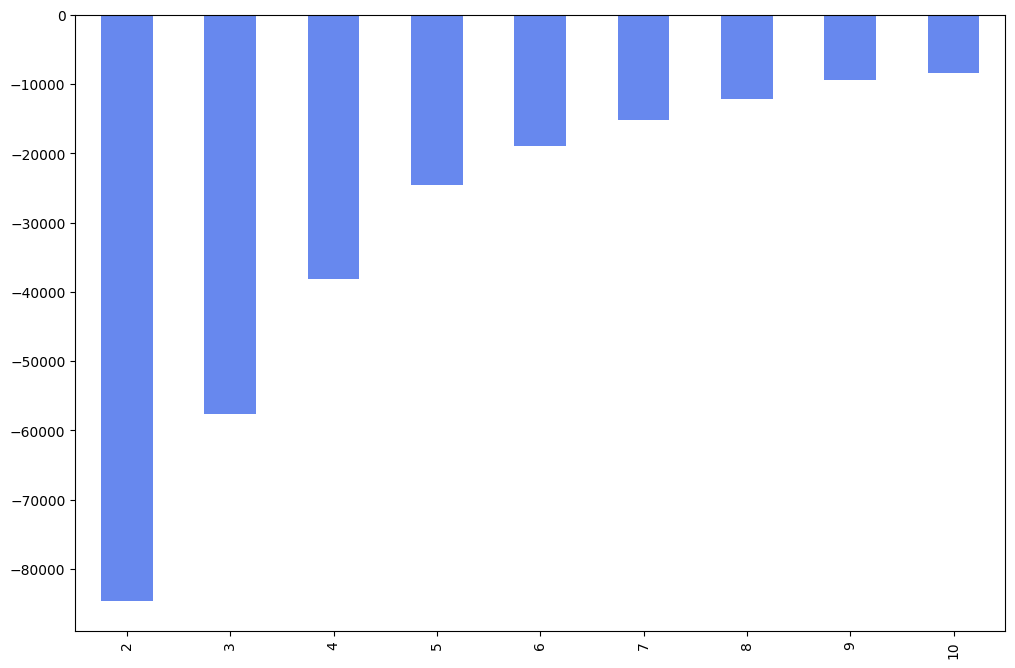

In [10]:
## K-Means Clustering 
scores = {}
for k in range(2, 11):
    print(k, end=', ')
    scores[k] = KMeans(n_clusters=k).fit(ds_transformed).score(ds_transformed)
_ = pd.Series(scores).plot.bar() ### Elbow Curve Plots 

In [11]:
## Create Clusters AND calculate silhoutte score 
valid_df["Cluster"] = KMeans(n_clusters=8).fit_predict(ds_transformed) + 1
silh_metric_score = silhouette_score(ds_transformed, valid_df["Cluster"], sample_size=15000)
print(f"Silhouette Score: {silh_metric_score:.2f}")

Silhouette Score: 0.67


In [12]:
## Determine the feature importance of resulting variables in the clusters
fs1 = ["latitude", "longitude", "attack_count"]
fs2 = ["ISIS Khorasan", "LTTE", "Maoists", "JVP", "Sikh Extremists", "Taliban", "TTP", "ULFA", "Unknown"]
subdf1 = ds_transformed[fs1]  # Just location parameters  
subdf2 = ds_transformed[fs2]  # Refers to group names and weaponry count used by them

for df in [subdf1, subdf2]: 
    ds_transformed["Cluster"] = KMeans(n_clusters=8).fit_predict(ds_transformed) + 1
    silh_metric_score = silhouette_score(ds_transformed, ds_transformed["Cluster"], sample_size=15000)
    print(f"Silhouette Score: {silh_metric_score:.2f}")
    print()

Silhouette Score: 0.76

Silhouette Score: 0.74



In [13]:
df["cluster_KMeans"] = ds_transformed["Cluster"]
ds_transformed.drop("Cluster", axis = 1, inplace = True)

**Observations & Conclusions** 
- Here we can observe that there is a large difference in silhoutte scores using different feature subsets, which indicates that terrorist group names and weaponry used have a greater say in dtermining clusters 

**Heirarchical Clustering**

## Affinity Propagation Clustering Algorithm 

In [86]:
from sklearn.cluster import AffinityPropagation 
af = AffinityPropagation(random_state = 0).fit(ds_transformed)

MemoryError: Unable to allocate 10.2 GiB for an array with shape (36994, 36994) and data type float64

In [ ]:
labels = af.labels_

In [17]:
df

ISIS Khorasan  LTTE  Maoists  JVP  Sikh Extremists  Taliban  TTP  ULFA  \
0                  0     0        0    0                0        0    0     0   
1                  0     0        0    0                0        0    0     0   
2                  0     0        0    0                0        0    0     0   
3                  0     1        0    0                0        0    0     0   
4                  0     0        0    0                0        0    0     0   
...              ...   ...      ...  ...              ...      ...  ...   ...   
36989              1     0        0    0                0        0    0     0   
36990              0     0        0    0                0        1    0     0   
36991              0     0        0    0                0        1    0     0   
36992              0     0        0    0                0        0    0     0   
36993              0     0        0    0                0        0    0     0   

       Unknown  cluster_KMeans  
0            1               3  
1            1               3  
2            1               3  
3            0               6  
4            1               3  
...        ...             ...  
36989        0               5  
36990        0               1  
36991        0               1  
36992        1               3  
36993        1               2  

[36994 rows x 10 columns]

## BIRCH Clustering Algorithm 


- Add BIRCH threshold 
- Add the algorithm description 
- Add a comparative analysis view of all clustering algorithms later in the section 
- Think on why BIRCH model has no random_state parameter 
- Check if the other plotly map can be used here 

In [14]:
from itertools import cycle 
from time import time

In [16]:
# Import and instantiate the BIRCH model 
from sklearn.cluster import Birch 

# Defining two sample BIRCH models, one consisting of global clustering and the other without it 
birch_models = [
    Birch(threshold=1.7, n_clusters=None),
    Birch(threshold=1.7, n_clusters=8)
]

# Define labels for the final step (used for printing and plotting)
final_step = ["without global clustering", "with global clustering"]


# Loop through each BIRCH model and corresponding label 
for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)): 
    t = time()
    birch_model.fit(ds_transformed)
    print("BIRCH %s as the final step took %0.2f seconds" % (info, (time() - t)))
    
    # Extract clustering results
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)
    
    # Plot the clustering results 

In [20]:
ds_transformed

latitude  longitude  attack_count  ISIS Khorasan  LTTE  Maoists  JVP  \
0     -0.464642  -0.523160      0.831581              0     0        0    0   
1      0.687002  -0.102743      0.831581              0     0        0    0   
2      0.634948   0.043800      0.831581              0     0        0    0   
3     -2.388248   0.708891     -1.437906              0     1        0    0   
4      0.002177   0.434571      0.831581              0     0        0    0   
...         ...        ...           ...            ...   ...      ...  ...   
36989  0.738946  -0.206824     -1.582441              1     0        0    0   
36990  0.713763  -0.335058     -0.782119              0     0        0    0   
36991  0.852449  -0.745878     -0.782119              0     0        0    0   
36992  0.928963  -0.749797      0.831581              0     0        0    0   
36993 -0.476363   2.040713      0.831581              0     0        0    0   

       Sikh Extremists  Taliban  TTP  ULFA  Unknown  
0                    0        0    0     0        1  
1                    0        0    0     0        1  
2                    0        0    0     0        1  
3                    0        0    0     0        0  
4                    0        0    0     0        1  
...                ...      ...  ...   ...      ...  
36989                0        0    0     0        0  
36990                0        1    0     0        0  
36991                0        1    0     0        0  
36992                0        0    0     0        1  
36993                0        0    0     0        1  

[36994 rows x 12 columns]

In [21]:
import sklearn


print(sklearn.__version__)

1.2.0rc1


In [32]:
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Sagar Study\ML and Learning\Projects\global terrorism\terrorism_project\terrorismvenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import Birch 
import matplotlib.colors as colors 

# Create a subplot for each BIRCH model
fig = make_subplots(rows=1, cols=2)

# Define two Birch clustering models with different configurations
birch_models = [
    Birch(threshold=1.7, n_clusters=None),   # Birch without global clustering
    Birch(threshold=1.7, n_clusters=8),    # Birch with global clustering and 100 clusters
]

# Define labels for the final step (used for printing and plotting)
final_step = ["without global clustering", "with global clustering"]

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

# Loop through each Birch model and corresponding label
for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    # Measure the time taken to fit the Birch model on data X
    t = time()
    birch_model.fit(ds_transformed)
    print("BIRCH %s as the final step took %0.2f seconds" % (info, (time() - t)))

    # Extract clustering results
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)
    
    # Plot the clustering results
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
                
        # Scatter plot of data points
        fig.add_trace(go.Scattermapbox(
            lat=cluster_df.loc[mask, "latitude"],
            lon=cluster_df.loc[mask, "longitude"],
            mode='markers',
            marker=go.scattermapbox.Marker(size=9), 
            name=f'Cluster {k}'
        ))

        # if birch_model.n_clusters is None:
        #     # For Birch without global clustering, plot centroids
        #     fig1.add_trace(go.Scattermapbox(
        #         lat=ds_transformed.loc[],
        #         lon=[this_centroid[1]],
        #         mode='markers',
        #         marker=go.scattermapbox.Marker(size=9), 
        #         name=f'Centroid {k}'
        #     ))
 


# Update layout for better visualization
fig.update_layout(
    mapbox=dict(
        style="carto-positron",
        zoom=10,  # Adjust the zoom level as needed
        center=dict(lon=100, lat=20),  # Centered around Asia
    ),
    showlegend=True
)

# Show the plot
fig.show()

BIRCH without global clustering as the final step took 0.39 seconds
n_clusters : 4
BIRCH with global clustering as the final step took 0.40 seconds
n_clusters : 4


In [13]:
%pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Sagar Study\ML and Learning\Projects\global terrorism\terrorism_project\terrorismvenv\Scripts\python.exe -m pip install --upgrade pip' command.


## Mini-Batch KMeans 

In [25]:
from sklearn.cluster import MiniBatchKMeans

In [29]:
from os import cpu_count
print(cpu_count())

8


In [46]:
# Initialize the model 
mbk = MiniBatchKMeans(
    init="k-means++", 
    n_clusters=6, 
    batch_size=512*cpu_count(), 
    n_init=10,
    max_no_improvement=10, 
    verbose=0, 
    random_state=0 
)

# Compute running time of KMeans Algorithm after sampling 
t0 = time()

# Create clusters and calculate silhoutte score 
cluster_df["minibatch_kmeans_cluster"] = mbk.fit_predict(ds_transformed) + 1

# Calculate score 
silh_metric_score = silhouette_score(ds_transformed, valid_df["minibatch_kmeans_cluster"], sample_size=15000)

# Calculating CPU time for fitting and predicting the labels and calculating silhoutte score 
t_mini_batch = time() - t0
print(print(f"Silhouette Score: {silh_metric_score:.2f}"))
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)

Silhouette Score: 0.63
None
Time taken to run MiniBatchKMeans 3.55 seconds


In [38]:
valid_df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 'INT_IDEO',
       'INT_MISC', 'INT_ANY', 'related', 'minibatch_kmeans_cluster'],
      dtype='object', length=136)

In [41]:
valid_df["minibatch_kmeans_cluster"]

0        2
4        2
5        2
8        3
9        2
        ..
44146    1
44147    1
44148    1
44150    2
44151    4
Name: minibatch_kmeans_cluster, Length: 36994, dtype: int32

Text(0, 0.5, 'Frequency')

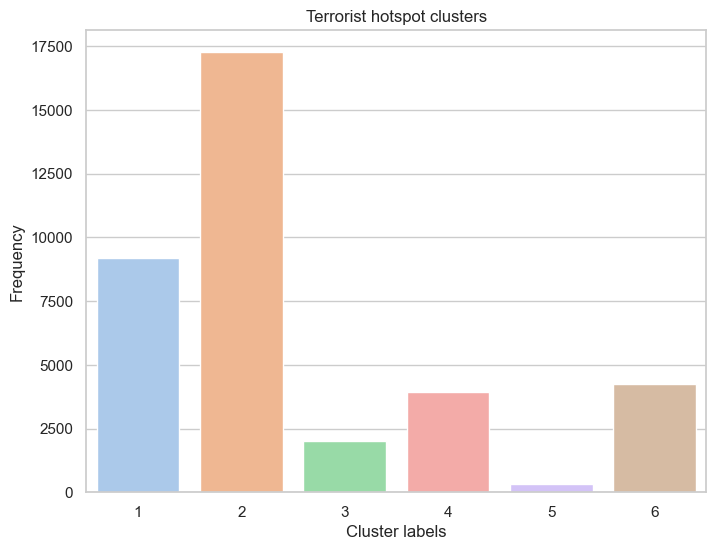

In [47]:
# Print the frequency distribution of the 8 clusters 
plt.figure(figsize=(8, 6))
sns.countplot(data=valid_df, x="minibatch_kmeans_cluster", palette="pastel")

# Adding labels and title 
plt.title("Terrorist hotspot clusters")
plt.xlabel("Cluster labels")
plt.ylabel("Frequency")

- Based on the provided feature values, the clusters are...

In [43]:
import plotly.express as px 

In [48]:
cluster_df

latitude  longitude                                    gname  \
0      24.891115  67.143311                                  Unknown   
4      34.006004  71.537430                                  Unknown   
5      33.594013  73.069077                                  Unknown   
8       9.666399  80.020477  Liberation Tigers of Tamil Eelam (LTTE)   
9      28.585836  77.153336                                  Unknown   
...          ...        ...                                      ...   
44146  34.417122  70.449593    Khorasan Chapter of the Islamic State   
44147  34.217806  69.109316                                  Taliban   
44148  35.315467  64.815508                                  Taliban   
44150  35.921051  64.774544                                  Unknown   
44151  24.798346  93.940430                                  Unknown   

                                           weaptype1_txt  \
0      Vehicle (not to include vehicle-borne explosiv...   
4                                             Explosives   
5                                             Explosives   
8                                               Firearms   
9                                             Explosives   
...                                                  ...   
44146                                         Explosives   
44147                                         Explosives   
44148                                           Firearms   
44150                                         Explosives   
44151                                         Explosives   

       minibatch_kmeans_cluster  
0                             2  
4                             2  
5                             2  
8                             3  
9                             2  
...                         ...  
44146                         1  
44147                         1  
44148                         1  
44150                         2  
44151                         4  

[36994 rows x 5 columns]

In [69]:
# Plot the minibatch clusters 
fig = px.scatter_geo(cluster_df, lat=cluster_df["latitude"], lon=cluster_df["longitude"], \
               color=cluster_df["minibatch_kmeans_cluster"], hover_name="gname", \
               color_discrete_sequence=px.colors.qualitative.Plotly, scope="asia", height=500, \
               width=1000)

# Adjust the default zoom size and center around India
fig.update_geos(
    center=dict(lon=78, lat=22),  # Set the center around India
    projection_scale=2,  # Adjust the zoom level
)

# Show the plot
fig.show()